### 데이터 설명

In [1]:
## 얼마나 팔당댐 컬럼을 밀어야 할까
# 청담대교: 27
# 잠수교: 9
# 한강대교: 12
# 행주대교: 31

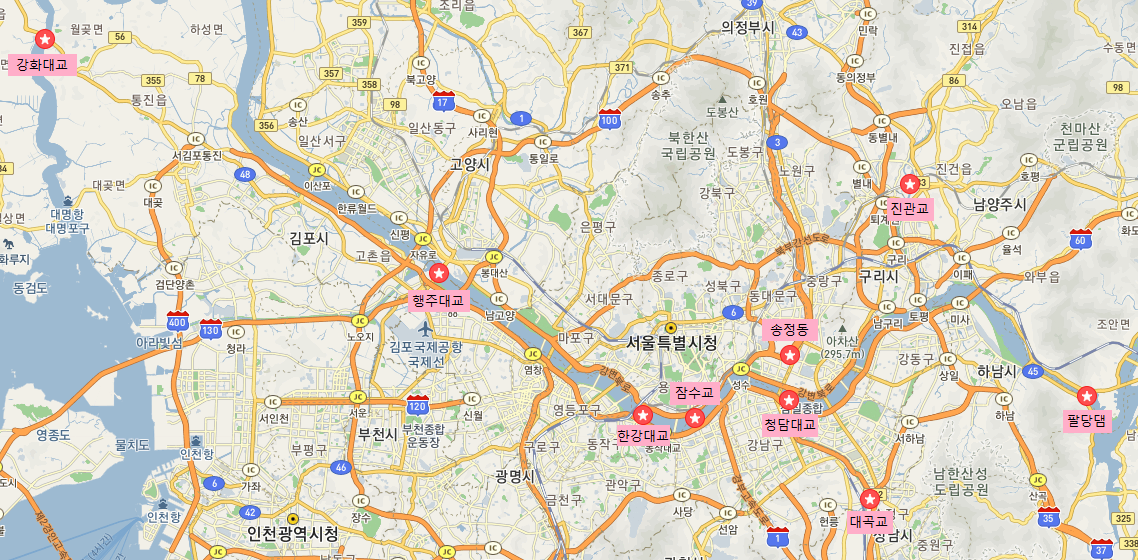

In [1]:
%matplotlib inline
from IPython.display import Image
Image('map.png')

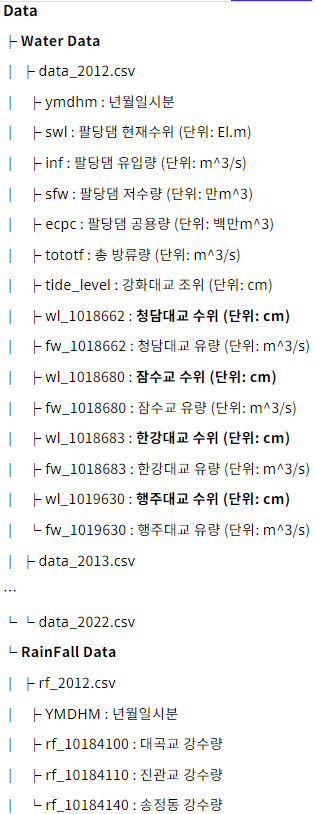

In [1]:
%matplotlib inline
from IPython.display import Image
Image('데이터 설명.png')

### 전처리 공통부분

In [4]:
import pandas as pd
import numpy as np
import os
import warnings; warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import all_estimators
pd.set_option('display.max_columns', None)

In [70]:
def read_csv_by_dir(path, index_col=None):
    df_raw = pd.DataFrame()
    df = pd.DataFrame()
    for files in os.listdir(path):
        if files.endswith('.csv'):
            df = pd.read_csv('/'.join([path,files]), index_col=index_col)
        df_raw = pd.concat((df_raw, df),axis=0)
    return df_raw

_df_rf_raw = read_csv_by_dir('./competition_data/rf_data', index_col=0)
_df_water_raw = read_csv_by_dir('./competition_data/water_data', index_col=0)
_submission_raw = pd.read_csv('./competition_data/sample_submission.csv', index_col=0)

# raw_data 보존하기
df_rf=_df_rf_raw.copy()
df_rf.name = "rain_data"
df_water=_df_water_raw.copy()
df_water.name = "water_data"
submission=_submission_raw.copy()
submission.name = "submission"

def index_to_datetime(df,format):
    df.index = pd.to_datetime(df.index, format=format)
    return df

df_rf=index_to_datetime(df=df_rf,format='%Y-%m-%d %H:%M')
df_water=index_to_datetime(df=df_water,format='%Y-%m-%d %H:%M')
submission=index_to_datetime(df=submission,format='%Y-%m-%d %H:%M')

df_rf.sort_index(inplace=True)
df_water.sort_index(inplace=True)
submission.sort_index(inplace=True)

# 데이터 시간대 확인하기
def check_datetime(df):
    print(df.name)
    print(df.select_dtypes('datetime64[ns]').head(1).index[0])
    print(df.select_dtypes('datetime64[ns]').tail(1).index[0])
    return None

# check_datetime(df_rf)
# check_datetime(df_water)
# check_datetime(submission)

# data target 분리하기
target = df_water.loc[:,submission.columns]
data = pd.concat((df_rf,df_water.drop(submission.columns,axis=1)),axis=1)

total=pd.concat((data,target),axis=1)
total=total.sort_index()
# print(total.head(1))

train_data=total.loc[:"2022-05-31",:"fw_1019630"].reset_index(drop=True)
train_target=total.loc[:"2022-05-31", "wl_1018662":].reset_index(drop=True)
test_data=total.loc["2022-05-31 23:50":"2022-07-18 23:40", :"fw_1019630"].reset_index(drop=True)
test_target=total.loc["2022-05-31 23:50":"2022-07-18 23:40", "wl_1018662":].reset_index(drop=True)

### 유량 보간법으로 채우기

In [72]:
total['fw_1018662'] = total['fw_1018662'].interpolate()
total['fw_1018683'] = total['fw_1018683'].interpolate()
total['fw_1019630'] = total['fw_1019630'].interpolate()
total['tide_level'] = total['tide_level'].interpolate()
total['swl'] = total['swl'].interpolate()
total['sfw'] = total['sfw'].interpolate()
total['ecpc'] = total['ecpc'].interpolate()
total['tototf'] = total['tototf'].interpolate()
total['inf'] = total['inf'].replace(0, np.nan).interpolate()

#잠수교 유량 지우기
total.drop('fw_1018680', axis=1, inplace=True)

In [73]:
train_data=total.loc[:"2022-05-31",:"fw_1019630"].reset_index(drop=True)
train_target=total.loc[:"2022-05-31", "wl_1018662":].reset_index(drop=True)
test_data=total.loc["2022-05-31 23:50":"2022-07-18 23:40", :"fw_1019630"].reset_index(drop=True)
test_target=total.loc["2022-05-31 23:50":"2022-07-18 23:40", "wl_1018662":].reset_index(drop=True)

In [75]:
train_target = train_target.interpolate()

In [76]:
train_data.count(), train_target.count(), test_data.count(), test_target.count()

(rf_10184100    269424
 rf_10184110    269424
 rf_10184140    269424
 swl            269424
 inf            269424
 sfw            269424
 ecpc           269424
 tototf         269424
 tide_level     269424
 fw_1018662     269424
 fw_1018683     269424
 fw_1019630     269424
 dtype: int64,
 wl_1018662    269424
 wl_1018680    269424
 wl_1018683    269424
 wl_1019630    269424
 dtype: int64,
 rf_10184100    6912
 rf_10184110    6912
 rf_10184140    6912
 swl            6912
 inf            6912
 sfw            6912
 ecpc           6912
 tototf         6912
 tide_level     6912
 fw_1018662     6912
 fw_1018683     6912
 fw_1019630     6912
 dtype: int64,
 wl_1018662    6912
 wl_1018680    6912
 wl_1018683    6912
 wl_1019630    6912
 dtype: int64)

### 예측

In [77]:
def 점수산정_each_bridge(pred, select):
    # 청담대교, 잠수교, 한강대교, 행주대교
    # 'wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630'
    평가_데이터 = pd.read_csv("./평가지표/평가지표데이터.csv") # 자체 평가 점수를 구하기 위한 데이터
    평가_데이터 = 평가_데이터[[select]]
    평가_데이터 = 평가_데이터.T.to_numpy()[0]
    rmse =  (mean_squared_error(평가_데이터, pred))**0.5
    r2 = r2_score(평가_데이터, pred)
    return rmse/r2

In [78]:
total_train = pd.concat([train_data, train_target], axis=1)
total_train = total_train.iloc[:-1,:]
total_target = train_target.drop(0).reset_index(drop=True)
total_target = total_target.rename(columns={'wl_1018662':'10m_1018662', 'wl_1018680':'10m_1018680', 'wl_1018683':'10m_1018683', 'wl_1019630':'10m_1019630'})

total_test = pd.concat([test_data, test_target], axis=1)
평가_데이터 = pd.read_csv("./평가지표/평가지표데이터.csv") # 10분 전 수위 채워주기 위해
total_test.iloc[1:,-4:] = 평가_데이터.iloc[:-1,-4:]

In [79]:
sub_result = []

In [123]:
# 청담대교: 27 '10m_1018662' 'wl_1018662'
bridge_target = total_target[['10m_1018662']]

kfold = KFold(n_splits=2, shuffle=True)
rf = RandomForestRegressor(n_jobs=-1)
params = { "n_estimators" : [200, 250, 280] }
grid_cv = GridSearchCV(rf, param_grid=params, cv = kfold, n_jobs=-1)
grid_cv.fit(total_train, bridge_target)
pred=grid_cv.predict(total_test)

score = 점수산정_each_bridge(pred, 'wl_1018662')
print(f"{bridge_target.columns[0]} 점수: {score:.7f}") # 청담대교 1.8569826768355493, 잠수교 유량제거 1.851639
sub_result.append(('청담대교', 0, score, pred)) #1: 1.8713267 #2: 1.8662891
print(grid_cv.best_params_)
print(grid_cv.best_score_)
print(grid_cv)

10m_1018662 점수: 1.8684882
{'n_estimators': 280}
0.999523805703841
GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'n_estimators': [200, 250, 280]})


In [81]:
# 잠수교: 9  '10m_1018680' 'wl_1018680'
bridge_target = total_target[['10m_1018680']]

kfold = KFold(n_splits=2, shuffle=True)
rf = RandomForestRegressor(n_jobs=-1)
params = { "n_estimators" : [250] }
grid_cv = GridSearchCV(rf, param_grid=params, cv = kfold, n_jobs=-1)
grid_cv.fit(total_train, bridge_target)
pred=grid_cv.predict(total_test)

score = 점수산정_each_bridge(pred, 'wl_1018680')
print(f"{bridge_target.columns[0]} 점수: {score:.7f}") # 청담대교 1.8569826768355493, 잠수교 유량제거 1.851639
sub_result.append(('잠수교', 0, score, pred))

10m_1018680 점수: 1.5028517


In [82]:
# 한강대교: 12 '10m_1018683' 'wl_1018683'
bridge_target = total_target[['10m_1018683']]

kfold = KFold(n_splits=2, shuffle=True)
rf = RandomForestRegressor(n_jobs=-1)
params = { "n_estimators" : [250] }
grid_cv = GridSearchCV(rf, param_grid=params, cv = kfold, n_jobs=-1)
grid_cv.fit(total_train, bridge_target)
pred=grid_cv.predict(total_test)

score = 점수산정_each_bridge(pred, 'wl_1018683')
print(f"{bridge_target.columns[0]} 점수: {score:.7f}") # 청담대교 1.8569826768355493, 잠수교 유량제거 1.851639
sub_result.append(('한강대교', 0, score, pred))

10m_1018683 점수: 1.6734524


In [83]:
# 행주대교: 31 '10m_1019630' 'wl_1019630'
bridge_target = total_target[['10m_1019630']]

kfold = KFold(n_splits=2, shuffle=True)
rf = RandomForestRegressor(n_jobs=-1)
params = { "n_estimators" : [250] }
grid_cv = GridSearchCV(rf, param_grid=params, cv = kfold, n_jobs=-1)
grid_cv.fit(total_train, bridge_target)
pred=grid_cv.predict(total_test)

score = 점수산정_each_bridge(pred, 'wl_1019630')
print(f"{bridge_target.columns[0]} 점수: {score:.7f}") # 청담대교 1.8569826768355493, 잠수교 유량제거 1.851639
sub_result.append(('행주대교', 0, score, pred))

10m_1019630 점수: 1.8332450


In [84]:
sub_result

[('청담대교',
  0,
  1.8662890518937798,
  array([279.192, 280.232, 282.908, ..., 292.228, 308.964, 322.704])),
 ('잠수교',
  0,
  1.5028517445353762,
  array([276.552, 276.708, 277.584, ..., 307.96 , 310.212, 315.536])),
 ('한강대교',
  0,
  1.6734524390964172,
  array([274.896, 274.22 , 274.028, ..., 308.716, 312.704, 317.572])),
 ('행주대교',
  0,
  1.8332450155859759,
  array([268.804, 266.892, 265.288, ..., 310.412, 310.976, 312.724]))]

In [85]:
sub = pd.DataFrame([sub_result[p][3] for p in range(4)], index=['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630']).T
sub.index = _submission_raw.index
sub

,wl_1018662,wl_1018680,wl_1018683,wl_1019630
ymdhm,,,,
2022-06-01 00:00,279.192,276.552,274.896,268.804
2022-06-01 00:10,280.232,276.708,274.220,266.892
2022-06-01 00:20,282.908,277.584,274.028,265.288
2022-06-01 00:30,285.272,277.880,274.000,262.256
2022-06-01 00:40,286.292,277.076,274.068,259.692
...,...,...,...,...
2022-07-18 23:10,288.160,291.096,296.692,306.396
2022-07-18 23:20,288.944,301.636,305.004,308.788
2022-07-18 23:30,292.228,307.960,308.716,310.412


In [86]:
def 전체_점수산정(pred): #df 4컬럼 형식
    target = pd.read_csv("./평가지표/평가지표데이터.csv")
    value = 0
    for i in pred.columns.unique()[1:]:
        rmse =  (mean_squared_error(target[[i]], pred[[i]]))**0.5
        r2 = r2_score(target[[i]], pred[[i]])
        value += rmse/r2
    print(f"점수: {value/4:.4f}")
    return value/4

In [87]:
전체_점수산정(sub)

점수: 1.2524


1.2523872998044423

### 팔당댐 컬럼 밀기

```
청담대교
 1컬럼 점수: 1.851878
 2컬럼 점수: 1.859641
 3컬럼 점수: 1.853328
 4컬럼 점수: 1.8642831239048439
 5컬럼 점수: 1.8577387810281123
 6컬럼 점수: 1.8413514083501736
 7컬럼 점수: 1.84788272427555
 8컬럼 점수: 1.8418098397907905
 9컬럼 점수: 1.837568306205564
10컬럼 점수: 1.8510175933252182
11컬럼 점수: 1.8556621605091455
12컬럼 점수: 1.8308896480888581
13컬럼 점수: 1.8400199154062766
14컬럼 점수: 1.849850119396044
15컬럼 점수: 1.842384126486488
16컬럼 점수: 1.8279753286611324
17컬럼 점수: 1.8329542203058626
18컬럼 점수: 1.8466243138286431
19컬럼 점수: 1.844314330255032
20컬럼 점수: 1.8364422663100524
21컬럼 점수: 1.8413746880286015
22컬럼 점수: 1.8333038314105685
23컬럼 점수: 1.8352639320134938
24컬럼 점수: 1.84477470821402
25컬럼 점수: 1.834433968739089
26컬럼 점수: 1.8357280108236234
27컬럼 점수: 1.822982588570628
28컬럼 점수: 1.8275930458084544
29컬럼 점수: 1.8386998744391214
30컬럼 점수: 1.8230117770299472
31컬럼 점수: 1.8301674169782665
32컬럼 점수: 1.8294807612601003
33컬럼 점수: 1.8299377155024952
34컬럼 점수: 1.8289288517577993
35컬럼 점수: 1.831046232171703
36컬럼 점수: 1.8612325313974283
37컬럼 점수: 1.8428558563900241
38컬럼 점수: 1.8242164215932177
39컬럼 점수: 1.851944348509489

잠수교
10m_1018680 00컬럼 점수: 1.5192471
10m_1018680 01컬럼 점수: 1.5076655
10m_1018680 02컬럼 점수: 1.5375203
10m_1018680 03컬럼 점수: 1.5282268
10m_1018680 04컬럼 점수: 1.5378827
10m_1018680 05컬럼 점수: 1.5120966
10m_1018680 06컬럼 점수: 1.5092090
10m_1018680 07컬럼 점수: 1.5064006
10m_1018680 08컬럼 점수: 1.5044811
10m_1018680 09컬럼 점수: 1.5040440
10m_1018680 10컬럼 점수: 1.5059617
10m_1018680 11컬럼 점수: 1.5142847
10m_1018680 12컬럼 점수: 1.5197390
10m_1018680 13컬럼 점수: 1.5145025
10m_1018680 14컬럼 점수: 1.5202814
10m_1018680 15컬럼 점수: 1.5259576
10m_1018680 16컬럼 점수: 1.5194091
10m_1018680 17컬럼 점수: 1.5186679
10m_1018680 18컬럼 점수: 1.5190982
10m_1018680 19컬럼 점수: 1.5230973
10m_1018680 20컬럼 점수: 1.5271652
10m_1018680 21컬럼 점수: 1.5226900
10m_1018680 22컬럼 점수: 1.5296781
10m_1018680 23컬럼 점수: 1.5277429
10m_1018680 24컬럼 점수: 1.5264344
10m_1018680 25컬럼 점수: 1.5230119
10m_1018680 26컬럼 점수: 1.5280044
10m_1018680 27컬럼 점수: 1.5274064
10m_1018680 28컬럼 점수: 1.5216671
10m_1018680 29컬럼 점수: 1.5334658
10m_1018680 30컬럼 점수: 1.5233537
10m_1018680 31컬럼 점수: 1.5319880
10m_1018680 32컬럼 점수: 1.5513376
10m_1018680 33컬럼 점수: 1.5468786
10m_1018680 34컬럼 점수: 1.5540859
10m_1018680 35컬럼 점수: 1.5679865
10m_1018680 36컬럼 점수: 1.5478751
10m_1018680 37컬럼 점수: 1.5630899
10m_1018680 38컬럼 점수: 1.5351849
10m_1018680 39컬럼 점수: 1.5303270
10m_1018680 40컬럼 점수: 1.5257384
10m_1018680 41컬럼 점수: 1.5353340
10m_1018680 42컬럼 점수: 1.5355607
10m_1018680 43컬럼 점수: 1.5369579
10m_1018680 44컬럼 점수: 1.5321035
10m_1018680 45컬럼 점수: 1.5442885
10m_1018680 46컬럼 점수: 1.5368344
10m_1018680 47컬럼 점수: 1.5509429
10m_1018680 48컬럼 점수: 1.5480233
10m_1018680 49컬럼 점수: 1.5368173
10m_1018680 50컬럼 점수: 1.5424103
10m_1018680 51컬럼 점수: 1.5503598
10m_1018680 52컬럼 점수: 1.5478502
10m_1018680 53컬럼 점수: 1.5369057
10m_1018680 54컬럼 점수: 1.5368367
10m_1018680 55컬럼 점수: 1.5368150
10m_1018680 56컬럼 점수: 1.5298773
10m_1018680 57컬럼 점수: 1.5349800
10m_1018680 58컬럼 점수: 1.5350505
10m_1018680 59컬럼 점수: 1.5465467
10m_1018680 60컬럼 점수: 1.5539347
10m_1018680 61컬럼 점수: 1.5424974
10m_1018680 62컬럼 점수: 1.5381422
10m_1018680 63컬럼 점수: 1.6066571
10m_1018680 64컬럼 점수: 1.5441186
10m_1018680 65컬럼 점수: 1.5492108
10m_1018680 66컬럼 점수: 1.5487158
10m_1018680 67컬럼 점수: 1.5439923
10m_1018680 68컬럼 점수: 1.5506537
10m_1018680 69컬럼 점수: 1.5410079
10m_1018680 70컬럼 점수: 1.5467936
10m_1018680 71컬럼 점수: 1.5435464
10m_1018680 72컬럼 점수: 1.5407988
10m_1018680 73컬럼 점수: 1.5485391
10m_1018680 74컬럼 점수: 1.5505064
10m_1018680 75컬럼 점수: 1.5468564
10m_1018680 76컬럼 점수: 1.5448670
10m_1018680 77컬럼 점수: 1.5488748
10m_1018680 78컬럼 점수: 1.5445650
10m_1018680 79컬럼 점수: 1.5456837
10m_1018680 80컬럼 점수: 1.5525992
10m_1018680 81컬럼 점수: 1.5560387
10m_1018680 82컬럼 점수: 1.5550965
10m_1018680 83컬럼 점수: 1.5540584
10m_1018680 84컬럼 점수: 1.5550319
10m_1018680 85컬럼 점수: 1.5540737
10m_1018680 86컬럼 점수: 1.5569834
10m_1018680 87컬럼 점수: 1.5583947
10m_1018680 88컬럼 점수: 1.5528747
10m_1018680 89컬럼 점수: 1.5534487
10m_1018680 90컬럼 점수: 1.5503950
10m_1018680 91컬럼 점수: 1.5538597
10m_1018680 92컬럼 점수: 1.5565041
10m_1018680 93컬럼 점수: 1.5540237
10m_1018680 94컬럼 점수: 1.5530023
10m_1018680 95컬럼 점수: 1.5551815
10m_1018680 96컬럼 점수: 1.5577587
10m_1018680 97컬럼 점수: 1.5512214
10m_1018680 98컬럼 점수: 1.5518968
10m_1018680 99컬럼 점수: 1.5510663

한강대교
10m_1018683 00컬럼 점수: 1.5519845
10m_1018683 01컬럼 점수: 1.5447768
10m_1018683 02컬럼 점수: 1.5398667
10m_1018683 03컬럼 점수: 1.5475022
10m_1018683 04컬럼 점수: 1.5525230
10m_1018683 05컬럼 점수: 1.5446839
10m_1018683 06컬럼 점수: 1.5467993
10m_1018683 07컬럼 점수: 1.5492909
10m_1018683 08컬럼 점수: 1.5422299
10m_1018683 09컬럼 점수: 1.5453955
10m_1018683 10컬럼 점수: 1.5450591
10m_1018683 11컬럼 점수: 1.5461999
10m_1018683 12컬럼 점수: 1.5408396
10m_1018683 13컬럼 점수: 1.5430155
10m_1018683 14컬럼 점수: 1.5486420
10m_1018683 15컬럼 점수: 1.5511037
10m_1018683 16컬럼 점수: 1.5462254
10m_1018683 17컬럼 점수: 1.5462926
10m_1018683 18컬럼 점수: 1.5536993
10m_1018683 19컬럼 점수: 1.5470232
10m_1018683 20컬럼 점수: 1.5452495
10m_1018683 21컬럼 점수: 1.5530118
10m_1018683 22컬럼 점수: 1.5458154
10m_1018683 23컬럼 점수: 1.5499441
10m_1018683 24컬럼 점수: 1.5515527
10m_1018683 25컬럼 점수: 1.5525373
10m_1018683 26컬럼 점수: 1.5487042
10m_1018683 27컬럼 점수: 1.5521756
10m_1018683 28컬럼 점수: 1.5490966
10m_1018683 29컬럼 점수: 1.5435628
10m_1018683 30컬럼 점수: 1.5470330
10m_1018683 31컬럼 점수: 1.5481012
10m_1018683 32컬럼 점수: 1.5532135
10m_1018683 33컬럼 점수: 1.5582529
10m_1018683 34컬럼 점수: 1.5596917
10m_1018683 35컬럼 점수: 1.5605702
10m_1018683 36컬럼 점수: 1.5659302
10m_1018683 37컬럼 점수: 1.5567405
10m_1018683 38컬럼 점수: 1.5518791
10m_1018683 39컬럼 점수: 1.5528114
10m_1018683 40컬럼 점수: 1.5492139
10m_1018683 41컬럼 점수: 1.5552950
10m_1018683 42컬럼 점수: 1.5505177
10m_1018683 43컬럼 점수: 1.5479724
10m_1018683 44컬럼 점수: 1.5543347
10m_1018683 45컬럼 점수: 1.5536452
10m_1018683 46컬럼 점수: 1.5515433
10m_1018683 47컬럼 점수: 1.5549120
10m_1018683 48컬럼 점수: 1.5539298
10m_1018683 49컬럼 점수: 1.5565867
10m_1018683 50컬럼 점수: 1.5522192
10m_1018683 51컬럼 점수: 1.5510395
10m_1018683 52컬럼 점수: 1.5532319
10m_1018683 53컬럼 점수: 1.5448115
10m_1018683 54컬럼 점수: 1.5466440
10m_1018683 55컬럼 점수: 1.5526429
10m_1018683 56컬럼 점수: 1.5547161
10m_1018683 57컬럼 점수: 1.5636758
10m_1018683 58컬럼 점수: 1.5611701
10m_1018683 59컬럼 점수: 1.5570599
10m_1018683 60컬럼 점수: 1.5641903
10m_1018683 61컬럼 점수: 1.5607223
10m_1018683 62컬럼 점수: 1.5539767
10m_1018683 63컬럼 점수: 1.5633513
10m_1018683 64컬럼 점수: 1.5570360
10m_1018683 65컬럼 점수: 1.5583219
10m_1018683 66컬럼 점수: 1.5617074
10m_1018683 67컬럼 점수: 1.5644406
10m_1018683 68컬럼 점수: 1.5670492
10m_1018683 69컬럼 점수: 1.5604305
10m_1018683 70컬럼 점수: 1.5525322
10m_1018683 71컬럼 점수: 1.5602238
10m_1018683 72컬럼 점수: 1.5500214
10m_1018683 73컬럼 점수: 1.5581117
10m_1018683 74컬럼 점수: 1.5490058
10m_1018683 75컬럼 점수: 1.5539479
10m_1018683 76컬럼 점수: 1.5547844
10m_1018683 77컬럼 점수: 1.5527907
10m_1018683 78컬럼 점수: 1.5562145
10m_1018683 79컬럼 점수: 1.5563812
10m_1018683 80컬럼 점수: 1.5534115
10m_1018683 81컬럼 점수: 1.5617579
10m_1018683 82컬럼 점수: 1.5639894
10m_1018683 83컬럼 점수: 1.5662753
10m_1018683 84컬럼 점수: 1.5693932
10m_1018683 85컬럼 점수: 1.5606910
10m_1018683 86컬럼 점수: 1.5556327
10m_1018683 87컬럼 점수: 1.5567505
10m_1018683 88컬럼 점수: 1.5563868
10m_1018683 89컬럼 점수: 1.5508301
10m_1018683 90컬럼 점수: 1.5635857
10m_1018683 91컬럼 점수: 1.5558127
10m_1018683 92컬럼 점수: 1.5625269
10m_1018683 93컬럼 점수: 1.5531115
10m_1018683 94컬럼 점수: 1.5568135
10m_1018683 95컬럼 점수: 1.5668315
10m_1018683 96컬럼 점수: 1.5605467
10m_1018683 97컬럼 점수: 1.5559393
10m_1018683 98컬럼 점수: 1.5627751
10m_1018683 99컬럼 점수: 1.5562393
10m_1018683 100컬럼 점수: 1.5590594
10m_1018683 101컬럼 점수: 1.5572928
10m_1018683 102컬럼 점수: 1.5541055
10m_1018683 103컬럼 점수: 1.5637513
10m_1018683 104컬럼 점수: 1.5532046
10m_1018683 105컬럼 점수: 1.5539790
10m_1018683 106컬럼 점수: 1.5687169
10m_1018683 107컬럼 점수: 1.5630285
10m_1018683 108컬럼 점수: 1.5590418
10m_1018683 109컬럼 점수: 1.5513280
10m_1018683 110컬럼 점수: 1.5527665
10m_1018683 111컬럼 점수: 1.5582451
10m_1018683 112컬럼 점수: 1.5535034
10m_1018683 113컬럼 점수: 1.5606301
10m_1018683 114컬럼 점수: 1.5583598
10m_1018683 115컬럼 점수: 1.5546074
10m_1018683 116컬럼 점수: 1.5511976
10m_1018683 117컬럼 점수: 1.5594170
10m_1018683 118컬럼 점수: 1.5524601
10m_1018683 119컬럼 점수: 1.5460959
10m_1018683 120컬럼 점수: 1.5578558
10m_1018683 121컬럼 점수: 1.5582964
10m_1018683 122컬럼 점수: 1.5513625
10m_1018683 123컬럼 점수: 1.5506738
10m_1018683 124컬럼 점수: 1.5474974
10m_1018683 125컬럼 점수: 1.5487198
10m_1018683 126컬럼 점수: 1.5559479
10m_1018683 127컬럼 점수: 1.5538974
10m_1018683 128컬럼 점수: 1.5582599
10m_1018683 129컬럼 점수: 1.5473209
10m_1018683 130컬럼 점수: 1.5566920
10m_1018683 131컬럼 점수: 1.5515997
10m_1018683 132컬럼 점수: 1.5503059
10m_1018683 133컬럼 점수: 1.5503199
10m_1018683 134컬럼 점수: 1.5508173
10m_1018683 135컬럼 점수: 1.5538134
10m_1018683 136컬럼 점수: 1.5576860
10m_1018683 137컬럼 점수: 1.5506411
10m_1018683 138컬럼 점수: 1.5582196
10m_1018683 139컬럼 점수: 1.5606199
10m_1018683 140컬럼 점수: 1.5541360
10m_1018683 141컬럼 점수: 1.5549041
10m_1018683 142컬럼 점수: 1.5523196
10m_1018683 143컬럼 점수: 1.5587213
10m_1018683 144컬럼 점수: 1.5545588
10m_1018683 145컬럼 점수: 1.5595648
10m_1018683 146컬럼 점수: 1.5576029
10m_1018683 147컬럼 점수: 1.5593705
10m_1018683 148컬럼 점수: 1.5516618
10m_1018683 149컬럼 점수: 1.5641205
10m_1018683 150컬럼 점수: 1.5487566
10m_1018683 151컬럼 점수: 1.5551086
10m_1018683 152컬럼 점수: 1.5549353
10m_1018683 153컬럼 점수: 1.5637422
10m_1018683 154컬럼 점수: 1.5630887

행주대교
10m_1019630 00컬럼 점수: 1.5641651
10m_1019630 01컬럼 점수: 1.5584033
10m_1019630 02컬럼 점수: 1.5561794
10m_1019630 03컬럼 점수: 1.5535894
10m_1019630 04컬럼 점수: 1.5559711
10m_1019630 05컬럼 점수: 1.5616514
10m_1019630 06컬럼 점수: 1.5757585
10m_1019630 07컬럼 점수: 1.5707134
10m_1019630 08컬럼 점수: 1.5490498
10m_1019630 09컬럼 점수: 1.5748457
10m_1019630 10컬럼 점수: 1.5537411
10m_1019630 11컬럼 점수: 1.5414863
10m_1019630 12컬럼 점수: 1.5386232
10m_1019630 13컬럼 점수: 1.5722014
10m_1019630 14컬럼 점수: 1.5497707
10m_1019630 15컬럼 점수: 1.5624224
10m_1019630 16컬럼 점수: 1.5797413
10m_1019630 17컬럼 점수: 1.5574155
10m_1019630 18컬럼 점수: 1.5946493
10m_1019630 19컬럼 점수: 1.5675807
10m_1019630 20컬럼 점수: 1.5611248
10m_1019630 21컬럼 점수: 1.5581922
10m_1019630 22컬럼 점수: 1.5383572
10m_1019630 23컬럼 점수: 1.5286511
10m_1019630 24컬럼 점수: 1.5511971
10m_1019630 25컬럼 점수: 1.5298228
10m_1019630 26컬럼 점수: 1.5268077
10m_1019630 27컬럼 점수: 1.5452097
10m_1019630 28컬럼 점수: 1.5552776
10m_1019630 29컬럼 점수: 1.5412537
10m_1019630 30컬럼 점수: 1.5274329
10m_1019630 31컬럼 점수: 1.5101067
10m_1019630 32컬럼 점수: 1.5384020
10m_1019630 33컬럼 점수: 1.5526976
10m_1019630 34컬럼 점수: 1.5384477
10m_1019630 35컬럼 점수: 1.5556269
10m_1019630 36컬럼 점수: 1.5684970
10m_1019630 37컬럼 점수: 1.5450424
10m_1019630 38컬럼 점수: 1.5551185
10m_1019630 39컬럼 점수: 1.5819303
10m_1019630 40컬럼 점수: 1.5582233
10m_1019630 41컬럼 점수: 1.5315379
10m_1019630 42컬럼 점수: 1.5562898
10m_1019630 43컬럼 점수: 1.5445280
10m_1019630 44컬럼 점수: 1.5356372
10m_1019630 45컬럼 점수: 1.5424097
10m_1019630 46컬럼 점수: 1.5412715
10m_1019630 47컬럼 점수: 1.5487092
10m_1019630 48컬럼 점수: 1.5448307
10m_1019630 49컬럼 점수: 1.5420912
10m_1019630 50컬럼 점수: 1.5471203
10m_1019630 51컬럼 점수: 1.5427975
10m_1019630 52컬럼 점수: 1.5496403
10m_1019630 53컬럼 점수: 1.5343930
10m_1019630 54컬럼 점수: 1.5268572
10m_1019630 55컬럼 점수: 1.5444687
10m_1019630 56컬럼 점수: 1.5255044
10m_1019630 57컬럼 점수: 1.5603662
10m_1019630 58컬럼 점수: 1.5476364
10m_1019630 59컬럼 점수: 1.5340323
10m_1019630 60컬럼 점수: 1.5532436
10m_1019630 61컬럼 점수: 1.5424823
10m_1019630 62컬럼 점수: 1.5322105
10m_1019630 63컬럼 점수: 1.5528208
10m_1019630 64컬럼 점수: 1.5539321
10m_1019630 65컬럼 점수: 1.5427962
10m_1019630 66컬럼 점수: 1.5479874
10m_1019630 67컬럼 점수: 1.5526928
10m_1019630 68컬럼 점수: 1.5531768
10m_1019630 69컬럼 점수: 1.5486739
10m_1019630 70컬럼 점수: 1.5572649
10m_1019630 71컬럼 점수: 1.5682426
10m_1019630 72컬럼 점수: 1.5647264
10m_1019630 73컬럼 점수: 1.5616726
10m_1019630 74컬럼 점수: 1.5574717
10m_1019630 75컬럼 점수: 1.5474615
10m_1019630 76컬럼 점수: 1.5588820
10m_1019630 77컬럼 점수: 1.5789084
10m_1019630 78컬럼 점수: 1.5622831
10m_1019630 79컬럼 점수: 1.5808405
10m_1019630 80컬럼 점수: 1.5586487
10m_1019630 81컬럼 점수: 1.5536077
10m_1019630 82컬럼 점수: 1.5672119
10m_1019630 83컬럼 점수: 1.5449900
10m_1019630 84컬럼 점수: 1.5494376
10m_1019630 85컬럼 점수: 1.5582971
10m_1019630 86컬럼 점수: 1.5428286
10m_1019630 87컬럼 점수: 1.5498763
10m_1019630 88컬럼 점수: 1.5644010
10m_1019630 89컬럼 점수: 1.5478953
10m_1019630 90컬럼 점수: 1.5517365
10m_1019630 91컬럼 점수: 1.5559073
10m_1019630 92컬럼 점수: 1.5408268
10m_1019630 93컬럼 점수: 1.5431344
10m_1019630 94컬럼 점수: 1.5427097
10m_1019630 95컬럼 점수: 1.5400633
10m_1019630 96컬럼 점수: 1.5343522
10m_1019630 97컬럼 점수: 1.5288705
10m_1019630 98컬럼 점수: 1.5363552
10m_1019630 99컬럼 점수: 1.5446074
10m_1019630 100컬럼 점수: 1.5359567
10m_1019630 101컬럼 점수: 1.5429896
10m_1019630 102컬럼 점수: 1.5433398
10m_1019630 103컬럼 점수: 1.5344548
10m_1019630 104컬럼 점수: 1.5465346
10m_1019630 105컬럼 점수: 1.5218373
10m_1019630 106컬럼 점수: 1.5269410
10m_1019630 107컬럼 점수: 1.5484220
10m_1019630 108컬럼 점수: 1.5269003
10m_1019630 109컬럼 점수: 1.5370762
10m_1019630 110컬럼 점수: 1.5182086
10m_1019630 111컬럼 점수: 1.5332365
10m_1019630 112컬럼 점수: 1.5564728
10m_1019630 113컬럼 점수: 1.5371403
10m_1019630 114컬럼 점수: 1.5244180
10m_1019630 115컬럼 점수: 1.5408732
10m_1019630 116컬럼 점수: 1.5292428
10m_1019630 117컬럼 점수: 1.5396603
10m_1019630 118컬럼 점수: 1.5451230
10m_1019630 119컬럼 점수: 1.5344139
10m_1019630 120컬럼 점수: 1.5333401
10m_1019630 121컬럼 점수: 1.5486373
10m_1019630 122컬럼 점수: 1.5345218
10m_1019630 123컬럼 점수: 1.5310733
10m_1019630 124컬럼 점수: 1.5317527
10m_1019630 125컬럼 점수: 1.5225721
10m_1019630 126컬럼 점수: 1.5263758
10m_1019630 127컬럼 점수: 1.5494774
10m_1019630 128컬럼 점수: 1.5486281
10m_1019630 129컬럼 점수: 1.5464119
10m_1019630 130컬럼 점수: 1.5507645
10m_1019630 131컬럼 점수: 1.5532219
10m_1019630 132컬럼 점수: 1.5353509
10m_1019630 133컬럼 점수: 1.5463062
10m_1019630 134컬럼 점수: 1.5335810
10m_1019630 135컬럼 점수: 1.5078860
10m_1019630 136컬럼 점수: 1.5240694
10m_1019630 137컬럼 점수: 1.5254467
10m_1019630 138컬럼 점수: 1.5227857
10m_1019630 139컬럼 점수: 1.5150886
10m_1019630 140컬럼 점수: 1.5300640
10m_1019630 141컬럼 점수: 1.5213779
10m_1019630 142컬럼 점수: 1.5212170
10m_1019630 143컬럼 점수: 1.5226980
10m_1019630 144컬럼 점수: 1.5287177
10m_1019630 145컬럼 점수: 1.5255723
10m_1019630 146컬럼 점수: 1.5409728
10m_1019630 147컬럼 점수: 1.5478515
10m_1019630 148컬럼 점수: 1.5413957
10m_1019630 149컬럼 점수: 1.5371336
10m_1019630 150컬럼 점수: 1.5266654
10m_1019630 151컬럼 점수: 1.5199750
10m_1019630 152컬럼 점수: 1.5116809
10m_1019630 153컬럼 점수: 1.5150662
10m_1019630 154컬럼 점수: 1.5234422
10m_1019630 155컬럼 점수: 1.5059762
10m_1019630 156컬럼 점수: 1.5088237

```

In [ ]:
# 청담대교: 27 '10m_1018662' 'wl_1018662'
# 잠수교: 9  '10m_1018680' 'wl_1018680'
# 한강대교: 12 '10m_1018683' 'wl_1018683'
# 행주대교: 31 '10m_1019630' 'wl_1019630'

### 

In [231]:
result={}
real_data = pd.read_csv('./waterfall_target(real).csv')
real_data.drop('ymdhm', axis=1, inplace=True)
test_combine_df = pd.concat([test_data, real_data], axis=1) # t시각의 수위를 구하기 위해 t-1시각의 test_data와 real_data를 합친다.
# 잠수교 유량 제거를 해야 하나
# randomforest는 컬럼 순서에 민감

def train_data_converter(data, x):
    if x==0: return data
    data = pd.concat( [ data[['rf_10184100', 'rf_10184110', 'rf_10184140']].iloc[: x*(-1), :].reset_index(drop=True), \
            data[['swl', 'inf', 'sfw', 'ecpc', 'tototf']].iloc[x:, : ].reset_index(drop=True), \
            data[['tide_level', 'fw_1018662', 'fw_1018680', 'fw_1018683', 'fw_1019630', 'wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630']].iloc[: x*(-1), :].reset_index(drop=True)], axis=1) # , 'rf_category', 'rf_sum'
    return data

def train_target_converter(data, x):
    # 청담대교, 잠수교, 한강대교, 행주대교
    # '10m_1018662', '10m_1018680', '10m_1018683', '10m_1019630'
    data.drop(['10m_1018662', '10m_1018683', '10m_1019630'], axis=1, inplace=True)
    if x==0: return data
    data = data.iloc[: x*(-1), :]
    return data

def train_target_converter_each_bridge(data, select, x):
    # 청담대교, 잠수교, 한강대교, 행주대교
    # '10m_1018662', '10m_1018680', '10m_1018683', '10m_1019630'
    bridge = ['10m_1018662', '10m_1018680', '10m_1018683', '10m_1019630']
    bridge.remove(select)
    data.drop(bridge, axis=1, inplace=True)
    if x==0: return data
    data = data.iloc[: x*(-1), :]
    return data

def 점수산정_each_bridge(pred, select):
    # 청담대교, 잠수교, 한강대교, 행주대교
    # 'wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630'
    평가_데이터 = pd.read_csv("./평가지표/평가지표데이터.csv") # 자체 평가 점수를 구하기 위한 데이터
    평가_데이터 = 평가_데이터[[select]]
    평가_데이터 = 평가_데이터.T.to_numpy()[0]
    rmse =  (mean_squared_error(평가_데이터, pred))**0.5
    r2 = r2_score(평가_데이터, pred)
    return rmse/r2

def 점수산정(pred):
    # 청담대교, 잠수교, 한강대교, 행주대교
    # 'wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630'
    평가_데이터 = pd.read_csv("./평가지표/평가지표데이터.csv") # 자체 평가 점수를 구하기 위한 데이터
    평가_데이터 = 평가_데이터[['wl_1018680']]
    평가_데이터 = 평가_데이터.T.to_numpy()[0]
    rmse =  (mean_squared_error(평가_데이터, pred))**0.5
    r2 = r2_score(평가_데이터, pred)
    return rmse/r2

def 전체_점수산정(pred): #df 4컬럼 형식
    target = pd.read_csv("./평가지표/평가지표데이터.csv")
    value = 0
    for i in pred.columns.unique()[1:]:
        rmse =  (mean_squared_error(target[[i]], pred[[i]]))**0.5
        r2 = r2_score(target[[i]], pred[[i]])
        value += rmse/r2
    print(f"점수: {value/4:.4f}")
    return value/4

In [ ]:
sub_result=[]
# 청담대교: 27 '10m_1018662' 'wl_1018662'
# 잠수교: 9  '10m_1018680' 'wl_1018680'
# 한강대교: 12 '10m_1018683' 'wl_1018683'
# 행주대교: 31 '10m_1019630' 'wl_1019630'

In [ ]:
# 강수량 0,1,2 범주화 (0->0, 0~10->1, 10~->2) #269392컬럼
train_data.loc[(train_data['rf_10184100'] > 0.0) & (train_data['rf_10184100'] <= 10.0),'rf_10184100'] = 1.0
train_data.loc[(train_data['rf_10184100'] > 10.0),'rf_10184100'] = 2.0
train_data.loc[(train_data['rf_10184110'] > 0.0) & (train_data['rf_10184110'] <= 10.0),'rf_10184110'] = 1.0
train_data.loc[(train_data['rf_10184110'] > 10.0),'rf_10184110'] = 2.0
train_data.loc[(train_data['rf_10184140'] > 0.0) & (train_data['rf_10184140'] <= 10.0),'rf_10184140'] = 1.0
train_data.loc[(train_data['rf_10184140'] > 10.0),'rf_10184140'] = 2.0

test_combine_df.loc[(test_combine_df['rf_10184100'] > 0.0) & (test_combine_df['rf_10184100'] <= 10.0),'rf_10184100'] = 1.0
test_combine_df.loc[(test_combine_df['rf_10184100'] > 10.0),'rf_10184100'] = 2.0
test_combine_df.loc[(test_combine_df['rf_10184110'] > 0.0) & (test_combine_df['rf_10184110'] <= 10.0),'rf_10184110'] = 1.0
test_combine_df.loc[(test_combine_df['rf_10184110'] > 10.0),'rf_10184110'] = 2.0
test_combine_df.loc[(test_combine_df['rf_10184140'] > 0.0) & (test_combine_df['rf_10184140'] <= 10.0),'rf_10184140'] = 1.0
test_combine_df.loc[(test_combine_df['rf_10184140'] > 10.0),'rf_10184140'] = 2.0

In [1]:
# 청담대교: 27 '10m_1018662' 'wl_1018662'
combine_df =  pd.concat([train_data, train_target], axis=1)
combine_df = combine_df.iloc[:-1,:]
combine_df = train_data_converter(combine_df, 27)

combine_df_target = train_target.drop(0).reset_index(drop=True)
combine_df_target = combine_df_target.rename(columns={'wl_1018662':'10m_1018662', 'wl_1018680':'10m_1018680', 'wl_1018683':'10m_1018683', 'wl_1019630':'10m_1019630'})
combine_df_target = train_target_converter_each_bridge(combine_df_target, '10m_1018662', 27)

kfold = KFold(n_splits=2, shuffle=True)
rf = RandomForestRegressor(n_jobs=-1)
params = { "n_estimators" : [250] }
grid_cv = GridSearchCV(rf, param_grid=params, cv = kfold, n_jobs=-1)
grid_cv.fit(combine_df, combine_df_target)
pred=grid_cv.predict(test_combine_df)

score = 점수산정_each_bridge(pred, 'wl_1018662')

# 주요 변수 출력
vari_df = pd.DataFrame([i for i in zip(test_combine_df.columns, grid_cv.best_estimator_.feature_importances_)])
# display(vari_df.sort_values(by=1, ascending=False))

print(f"{combine_df_target.columns[0]} {27:02d}컬럼 점수: {score:.7f}") # 청담대교 1.8569826768355493, 잠수교 유량제거 1.851639
sub_result.append(('청담대교', 27, score, pred))
# 10m_1018662 27컬럼 점수: 1.8450190 #강우량3컬럼012: 1.8404041 #3컬럼지우고1컬럼으로합침: 1.8329008 #3컬럼안지우고1컬럼뒤에생성:1.8440381
# 강수량 그대로 + 합계 그대로 + 합계범주화0~4: 1.8237654

10m_1018662 27컬럼 점수: 1.8452959


In [2]:
# 잠수교: 9  '10m_1018680' 'wl_1018680'
name = '잠수교'
num = 9
dat_1 = '10m_1018680'
dat_2 = 'wl_1018680'

combine_df =  pd.concat([train_data, train_target], axis=1)
combine_df = combine_df.iloc[:-1,:]
combine_df = train_data_converter(combine_df, num)

combine_df_target = train_target.drop(0).reset_index(drop=True)
combine_df_target = combine_df_target.rename(columns={'wl_1018662':'10m_1018662', 'wl_1018680':'10m_1018680', 'wl_1018683':'10m_1018683', 'wl_1019630':'10m_1019630'})
combine_df_target = train_target_converter_each_bridge(combine_df_target, dat_1, num)

kfold = KFold(n_splits=2, shuffle=True)
rf = RandomForestRegressor(n_jobs=-1)
params = { "n_estimators" : [250] }
grid_cv = GridSearchCV(rf, param_grid=params, cv = kfold, n_jobs=-1)
grid_cv.fit(combine_df, combine_df_target)
pred=grid_cv.predict(test_combine_df)

score = 점수산정_each_bridge(pred, dat_2)

# 주요 변수 출력
vari_df = pd.DataFrame([i for i in zip(test_combine_df.columns, grid_cv.best_estimator_.feature_importances_)])
# display(vari_df.sort_values(by=1, ascending=False))

print(f"{combine_df_target.columns[0]} {num:02d}컬럼 점수: {score:.7f}") # 청담대교 1.8569826768355493, 잠수교 유량제거 1.851639
sub_result.append((name, num, score, pred))
# 10m_1018680 09컬럼 점수: 1.5050781 #강우량3컬럼012: 1.5060545 #3컬럼지우고1컬럼으로합침: 1.5082575 #3컬럼안지우고1컬럼뒤에생성:1.5083361
# 0~6 1.5030620
# 강수량 그대로 + 합계 그대로 + 합계범주화0~4: 1.5049775

10m_1018680 09컬럼 점수: 1.5035295


In [3]:
# 한강대교: 12 '10m_1018683' 'wl_1018683'
name = '한강대교'
num = 12
dat_1 = '10m_1018683'
dat_2 = 'wl_1018683'

combine_df =  pd.concat([train_data, train_target], axis=1)
combine_df = combine_df.iloc[:-1,:]
combine_df = train_data_converter(combine_df, num)

combine_df_target = train_target.drop(0).reset_index(drop=True)
combine_df_target = combine_df_target.rename(columns={'wl_1018662':'10m_1018662', 'wl_1018680':'10m_1018680', 'wl_1018683':'10m_1018683', 'wl_1019630':'10m_1019630'})
combine_df_target = train_target_converter_each_bridge(combine_df_target, dat_1, num)

kfold = KFold(n_splits=2, shuffle=True)
rf = RandomForestRegressor(n_jobs=-1)
params = { "n_estimators" : [250] }
grid_cv = GridSearchCV(rf, param_grid=params, cv = kfold, n_jobs=-1)
grid_cv.fit(combine_df, combine_df_target)
pred=grid_cv.predict(test_combine_df)

score = 점수산정_each_bridge(pred, dat_2)

# 주요 변수 출력
vari_df = pd.DataFrame([i for i in zip(test_combine_df.columns, grid_cv.best_estimator_.feature_importances_)])
# display(vari_df.sort_values(by=1, ascending=False))

print(f"{combine_df_target.columns[0]} {num:02d}컬럼 점수: {score:.7f}") # 청담대교 1.8569826768355493, 잠수교 유량제거 1.851639
sub_result.append((name, num, score, pred))
# 10m_1018683 12컬럼 점수: 1.5385660 #강우량3컬럼012: 1.1.5449582 #3컬럼지우고1컬럼으로합침: 1.5512047 #3컬럼안지우고1컬럼뒤에생성:1.5455022
# 0~6 1.1.5373382
# 강수량 그대로 + 합계 그대로 + 합계범주화0~4: 1.5410632

10m_1018683 12컬럼 점수: 1.5488960


In [4]:
# 행주대교: 31 '10m_1019630' 'wl_1019630'
name = '행주대교'
num = 31
dat_1 = '10m_1019630'
dat_2 = 'wl_1019630'

combine_df =  pd.concat([train_data, train_target], axis=1)
combine_df = combine_df.iloc[:-1,:]
combine_df = train_data_converter(combine_df, num)

combine_df_target = train_target.drop(0).reset_index(drop=True)
combine_df_target = combine_df_target.rename(columns={'wl_1018662':'10m_1018662', 'wl_1018680':'10m_1018680', 'wl_1018683':'10m_1018683', 'wl_1019630':'10m_1019630'})
combine_df_target = train_target_converter_each_bridge(combine_df_target, dat_1, num)

kfold = KFold(n_splits=2, shuffle=True)
rf = RandomForestRegressor(n_jobs=-1)
params = { "n_estimators" : [250] }
grid_cv = GridSearchCV(rf, param_grid=params, cv = kfold, n_jobs=-1)
grid_cv.fit(combine_df, combine_df_target)
pred=grid_cv.predict(test_combine_df)

score = 점수산정_each_bridge(pred, dat_2)

# 주요 변수 출력
vari_df = pd.DataFrame([i for i in zip(test_combine_df.columns, grid_cv.best_estimator_.feature_importances_)])
# display(vari_df.sort_values(by=1, ascending=False))

print(f"{combine_df_target.columns[0]} {num:02d}컬럼 점수: {score:.7f}") # 청담대교 1.8569826768355493, 잠수교 유량제거 1.851639
sub_result.append((name, num, score, pred))
# 10m_1019630 31컬럼 점수: 1.5340809 #강우량3컬럼012: 1.5126590 #3컬럼지우고1컬럼으로합침: 1.5177055 #3컬럼안지우고1컬럼뒤에생성:1.5218230
# 0~6 1.5256954
# 강수량 그대로 + 합계 그대로 + 합계범주화0~4: 1.5396707

10m_1019630 31컬럼 점수: 1.5200576


In [ ]:
combine_df.to_csv('검증.csv')

In [ ]:
sub = pd.DataFrame([sub_result[p][3] for p in range(4)], index=['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630']).T
sub.index = _submission_raw.index

In [8]:
전체_점수산정(sub)
# 강수량 변환 전: 1.1433182707270415 # 강수량3컬럼을 범주화: 1.1412028661826048 # 강수량 3->1컬럼 합치기: 1.144291932264781
# 3컬럼원본유지+1컬럼생성012: 1.1439153376918534

점수: 1.1431

1.1431207496249713
